In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from scipy.integrate import quad
from scipy.optimize import minimize
import time

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 28}
font1 = {'family': 'serif', 'size': 24}

In this file you can see the code for RNN test.

In [2]:
# def sample_gaussian_distribution(d):
#     v = np.random.normal(0,1, size=d) 
#     return v

# def euclidean_projection(point, lower_bounds, upper_bounds):
#     def objective_function(z):
#         return np.linalg.norm(z - point) ** 2

#     constraints = []
#     for i in range(len(lower_bounds)):
#         constraints.append({'type': 'ineq', 'fun': lambda z, i=i: z[i] - lower_bounds[i]})
#         constraints.append({'type': 'ineq', 'fun': lambda z, i=i: upper_bounds[i] - z[i]})

#     result = minimize(objective_function, point, constraints=constraints, method='COBYLA')
#     return result.x

def grad(func,x,mu=0.05):
    u = np.random.normal(0,1, size=len(x))
    g = (func(x+mu*u)-func(x))/mu
    return g*u


def step(func,x,h,mu=0.05):
    grd = grad(func,x,mu)
    xx = x - h*grd
    return xx

def RM(func,x0,T,h = 0.001,mu=0.05,flag2 = 'not_c',lower_bounds=[],upper_bounds=[]):
    dim1 = len(x0)
    x=np.zeros((dim1,T+1))
    x[:,0]=x0.ravel()
    if flag2 == 'not_c':
        for k in range(T):
          x[:,k+1] = step(func,x[:,k],h,mu)
    # if flag2 == 'c':
    #     for k in range(T):
    #       x[:,k+1] =euclidean_projection(step(func,x[:,k],h,mu),lower_bounds,upper_bounds)
    return x

def f(x):
    return np.sum(x**4 + x**2 - x)
x0 = np.array([5, -5])
print("final X with g",Nesterov(f,x0,10000,h = 0.001,mu=0.005)[:,-1])

final X with g [0.38544298 0.38520139]


In [5]:
N = 500
T = 100
d = 20
T1 = T // 10

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_grad(x):
    return sigmoid(x)(1-sigmoid(x))

def generate_training_data(N, T, d):
    # Generate input sequences x and output sequences y
    x = np.random.randn(N, T)
    y = np.random.randn(N, T)

    return x, y

def combine_params(A, B, C, D):
    # Flatten matrix A to a 1D array
    A_flat = A.flatten().reshape(-1,1)
    
    # Concatenate A_flat, C, and D into a single vector
    combined_vector = np.concatenate((A_flat, B, C.T, np.array(D).reshape(-1,1)))

    return combined_vector

def split_params(combined_vector, d):
    # Extract matrix A from combined_vector
    A_size = d * d
    A = combined_vector[:A_size].reshape(d, d)
    B = combined_vector[A_size:A_size + d]
    # Extract vector C from combined_vector
    C = combined_vector[A_size + d:A_size + 2*d]

    # Extract scalar D from combined_vector
    D = combined_vector[-1]

    return A,B , C, D


def evaluate_loss(theta_hat_0):
    """
    Evaluate the loss function for the given parameters theta_hat.
    """
    A_hat,B_hat, C_hat, D_hat = split_params(theta_hat_0,d)
    C_hat = C_hat.T
    M = x.shape[0]  # Number of training examples
    T = x.shape[1]  # Length of each sequence
    
    loss = 0
    for i in range(M):
        h_hat = np.zeros((T+1, d))  # Estimated hidden states
        h_hat[0] = np.zeros(d)  # Initial estimated hidden state
    
        for t in range(T1, T):
            h_hat[t+1] = sigmoid(np.dot(A_hat, h_hat[t]).reshape(-1, 1)+ (B_hat*x[i, t]).reshape(-1,1)).ravel()
            y_hat = np.dot(C_hat, h_hat[t]) + np.dot(D_hat, x[i, t])
            loss += np.linalg.norm(y_hat - y[i, t])**2
    
    loss /= (M * (T - T1))
    
    return loss


def gradient_loss(theta_hat):
    """
    Compute the gradient of the loss function with respect to theta_hat.
    """
    A_hat,B_hat, C_hat, D_hat = split_params(theta_hat_0,d)
    C_hat = C_hat
    M = x.shape[0]  # Number of training examples
    T = x.shape[1]  # Length of each sequence
    
    grad_A = np.zeros((d, d))
    grad_C = np.zeros((1, d))
    grad_B = np.zeros((d, 1))
    grad_D = 0
    
    for i in range(M):
        h_hat = np.zeros((T+1, d))  # Estimated hidden states
        
        for t in range(T1, T):
            # Compute gradients of A_hat, C_hat, and D_hat
            h_hat[t+1] = sigmoid(np.dot(A_hat, h_hat[t]).reshape(-1, 1)+ (B_hat*x[i, t]).reshape(-1,1)).ravel()
            y_hat = np.dot(C_hat, h_hat[t]) + np.dot(D_hat, x[i, t])
            
            grad_D += (2 * (y_hat - y[i, t]) * x[i, t])
            grad_C += (2 * np.dot((y_hat - y[i, t]).reshape(1, -1), h_hat[t].reshape(1, -1)))
            grad_A += (2 * (y_hat - y[i, t]).reshape(-1, 1)* C_hat* h_hat[t-1]*(h_hat[t])*(1-h_hat[t]))
            grad_B += (2 * (y_hat - y[i, t])* C_hat*x[i,t-1]*h_hat[t]*(1-h_hat[t])).reshape(-1,1)

    grad_A /= (M * (T - T1))
    grad_B /= (M * (T - T1))
    grad_C /= (M * (T - T1))
    grad_D /= (M * (T - T1))
    
    # Flatten gradients into a single vector
    grad_theta = combine_params(grad_A, grad_B, grad_C, grad_D)
    
    return grad_theta


x, y= generate_training_data(N, T, d)
# Perturb parameters


theta_hat_0 = np.random.randn(d**2+2*d+1)
loss = evaluate_loss(theta_hat_0)
print("Loss:", loss)
# print("gradient", gradient_loss(w[0,:].reshape(-1,1)))

num_iterations = 1000
learning_rate = 0.0001
# learning_rate2 = 0.01
num_iterations2 = 1000

Loss: 26.340817393158904


In [6]:
MC = 3
execution_time = []
execution_time2 = []
# execution_time3 = []
f1 = np.zeros((num_iterations,MC))
losses = np.zeros((num_iterations2,MC))
# losses2 = np.zeros((num_iterations2,MC))

x, y= generate_training_data(N, T, d)

for j in range(MC):
    # Perturb parameters
    while(True):
        theta_hat_0 = np.random.randn(d**2+2*d+1)
        if evaluate_loss(theta_hat_0)>5 and evaluate_loss(theta_hat_0)<30:
            break
    print(evaluate_loss(theta_hat_0))
    start = time.time()
    ww=RM(evaluate_loss,theta_hat_0,num_iterations,h = 0.0001,mu=0.0001)
    end = time.time()
    execution_time.append(end-start)

    for i in range(num_iterations):
        f1[i,j] = evaluate_loss(ww[:,i])

    w = np.zeros((num_iterations2,np.shape(theta_hat_0)[0]))
    w[0,:]=theta_hat_0.ravel()

    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        grad_theta = gradient_loss(w[i,:].reshape(-1,1)).ravel()
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * grad_theta
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = evaluate_loss(w[i,:])
        losses[i,j] = current_loss

    # w1 = np.zeros((num_iterations2,np.shape(theta_hat_0)[0]))
    # w1[0,:]=theta_hat_0.ravel()

    # # Gradient Descent
    # start = time.time()
    # for i in range(num_iterations2-1):
    #     # Compute gradient
    #     grad_theta = gradient_loss(w1[i,:].reshape(-1,1)).ravel()
    #     # if np.linalg.norm(grad_theta)>=50:
    #     #     grad_theta = grad_theta/np.linalg.norm(grad_theta)*10
    #     # Update weights
    #     w1[i+1,:] =w1[i,:]-learning_rate2 * grad_theta
    #     # Compute loss
    # end = time.time()
    # execution_time3.append(end-start)

    # for i in range(num_iterations2):
    #     # Compute loss
    #     current_loss = evaluate_loss(w1[i,:])
    #     losses2[i,j] = current_loss


et = np.mean(execution_time)
et2 = np.mean(execution_time2)
# et3 = np.mean(execution_time3)
tim = np.linspace(0,et,num_iterations)
tim2 = np.linspace(0,et2,num_iterations2)
# tim3 = np.linspace(0,et3,num_iterations2)
f1_a = np.mean(f1,axis=1)
losses_a = np.mean(losses,axis=1)
# losses2_a = np.mean(losses2,axis=1)

f1_se = np.std(f1, axis=1)
losses_se = np.std(losses, axis=1)

8.42104106479519
6.536741901067388
26.69852623408936


In [13]:
# np.save('RNN_RM_losses.npy', f1)
# np.save('RNN_GD_losses.npy', losses)
# # np.save('RNN_GD_losses_clip.npy', losses2)
# np.save('RNN_tim.npy', tim)
# np.save('RNN_tim2.npy', tim2)
# # np.save('RNN_tim3.npy', tim3)
# np.save('RNN_et.npy',execution_time)
# np.save('RNN_et2.npy',execution_time2)
# # np.save('RNN_et3.npy',execution_time3)

# f1 = np.load('RNN_RM_losses.npy')
# losses = np.load('RNN_GD_losses.npy')
# # losses2 = np.load('RNN_GD_losses_clip.npy')
# f1_a = np.mean(f1,axis=1)
# losses_a = np.mean(losses,axis=1)
# f1_se = np.std(f1, axis=1)
# losses_se = np.std(losses, axis=1)
# # losses2_a = np.mean(losses2,axis=1)
# tim = np.load('RNN_tim.npy')
# tim2 = np.load('RNN_tim2.npy')
# # tim3 = np.load('RNN_tim3.npy')
# num_iterations = 1000
# num_iterations2= 1000

In [6]:
np.shape(f1)

(1000, 3)

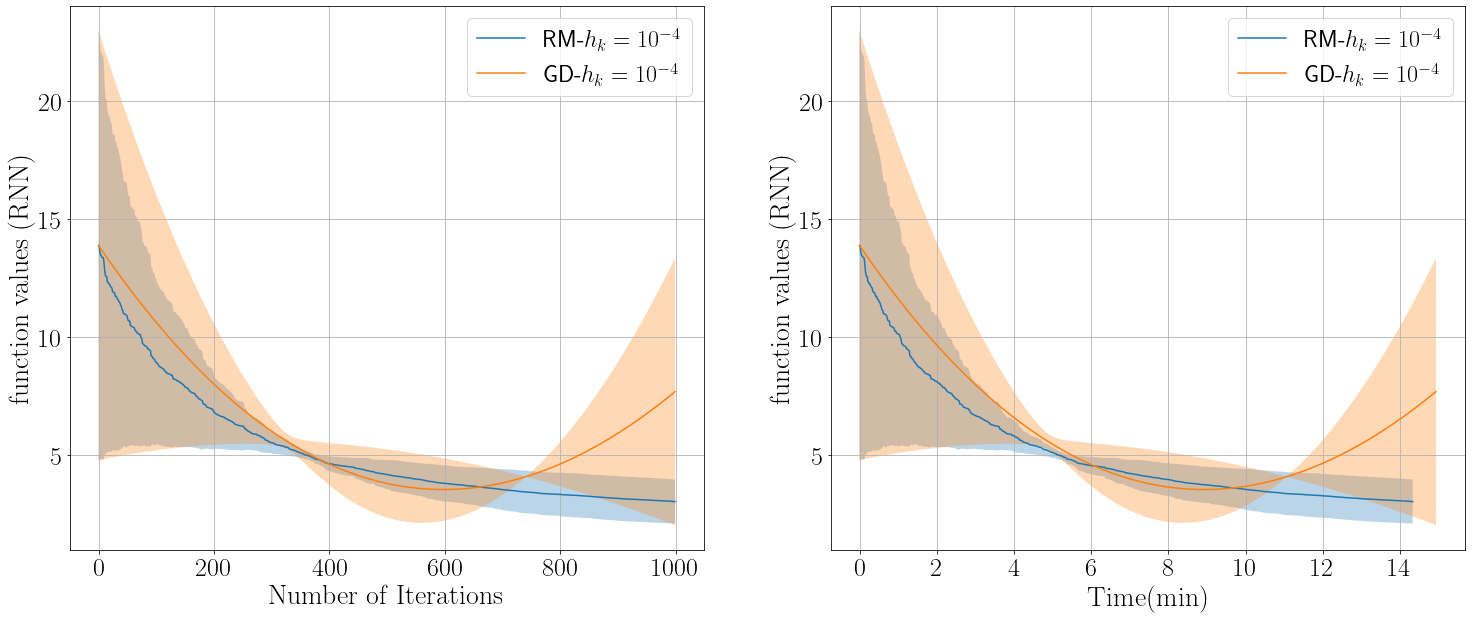

In [15]:
t = np.array(range(num_iterations))
t2 = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t,f1_a,label= r'RM-$h_k = 10^{-4}$')
plt.plot(t2,losses_a,label= r'GD-$h_k = 10^{-4}$')

plt.fill_between(t, f1_a - f1_se, f1_a + f1_se, alpha=0.3)
plt.fill_between(t2, losses_a - losses_se, losses_a + losses_se, alpha=0.3)


plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(RNN)}$', fontdict=font)
# plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim/60,f1_a,label= r'RM-$h_k = 10^{-4}$')
plt.plot(tim2/60,losses_a,label= r'GD-$h_k = 10^{-4}$')

plt.fill_between(tim/60, f1_a - f1_se, f1_a + f1_se, alpha=0.3)
plt.fill_between(tim2/60, losses_a - losses_se, losses_a + losses_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(min)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(RNN)}$', fontdict=font)
# plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
plt.savefig('Pics/RNN.pdf', format='pdf')